In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from statsmodels.stats import weightstats 

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

In [9]:
stud_math = pd.read_csv('stud_math.csv')

In [279]:
df = stud_math.copy()

# переименуем колонки для удобства
df.columns = ('school', 'sex', 'age', 'address', 'famsize',
                     'p_status', 'm_edu', 'f_edu', 'm_job', 'f_job',
                     'reason', 'guardian', 'traveltime', 'studytime',
                     'failures', 'schoolsup', 'famsup', 'paid',
                     'activities', 'nursery', 'studytime_granular',
                     'higher', 'internet', 'romantic', 'famrel',
                     'freetime', 'goout', 'health', 'absences', 'score')


# удалим пропущенные значения в переменной score
delete_df = df[df.score.isna()]
df = df.drop(delete_df.index)


def outliers_check(sample):
    ''' The function takes Pandas.Series
        then calculate outliers 
        and return df with them '''

    Q1 = sample.quantile(0.25)
    Q3 = sample.quantile(0.75)
    IQR = Q3 - Q1
    temp_df = pd.DataFrame(sample)
    temp_df['up_outliers'] = pd.Series(sample > (Q3 + IQR*1.5))
    temp_df['down_outliers'] = pd.Series(sample < (Q1 - IQR*1.5))

    if temp_df.up_outliers.nunique() == 1 and temp_df.down_outliers.nunique() == 1:
        return print('Выбросы не найдены')
    else:
        return temp_df[(temp_df.down_outliers == True) | (temp_df.up_outliers == True)]

    
def free_outliers_hist(sample, title, xlabel): 
    ''' The function takes Pandas.Series,
        calculate outliers,
        then draw a histogram without them'''
    
    Q1 = sample.quantile(0.25)
    Q3 = sample.quantile(0.75)
    IQR = Q3 - Q1

    sample.loc[sample.between(Q1 - 1.5*IQR,
    Q3 + 1.5*IQR)].hist(bins = 10, label = title)
    plt.xlabel(xlabel,fontsize = 12)
    plt.ylabel('frequence',fontsize = 12)
    plt.legend()
    

def delite_outliers(sample):
    ''' The function takes Pandas.Series,
        then calculate outliers 
        and return Pandas.Series without them '''
    
    Q1 = sample.quantile(0.25)
    Q3 = sample.quantile(0.75)
    IQR = Q3 - Q1
    temp_df = pd.DataFrame(sample)
    temp_df['up_outliers'] = pd.Series(sample > (Q3 + IQR*1.5))
    temp_df['down_outliers'] = pd.Series(sample < (Q1 - IQR*1.5))
    temp_df = temp_df[(temp_df['up_outliers'] == False) & (temp_df['down_outliers'] == False)]  
    
    return sample[temp_df.index]

### 1. Осмотр данных и проверка на пустые значения

In [20]:
display(df.head(10))
df.info() 

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               389 non-null    object 
 1   sex                  389 non-null    object 
 2   age                  389 non-null    int64  
 3   address              374 non-null    object 
 4   famsize              362 non-null    object 
 5   p_status             344 non-null    object 
 6   m_edu                386 non-null    float64
 7   f_edu                365 non-null    float64
 8   m_job                370 non-null    object 
 9   f_job                353 non-null    object 
 10  reason               372 non-null    object 
 11  guardian             358 non-null    object 
 12  traveltime           361 non-null    float64
 13  studytime            382 non-null    float64
 14  failures             367 non-null    float64
 15  schoolsup            380 non-null    obj

In [76]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,389.0,16.673522,1.265662,15.0,16.0,17.0,18.0,22.0
m_edu,386.0,2.766839,1.094277,0.0,2.0,3.0,4.0,4.0
f_edu,365.0,2.627397,2.241790,0.0,2.0,3.0,3.0,40.0
traveltime,361.0,1.434903,0.692660,1.0,1.0,1.0,2.0,4.0
studytime,382.0,2.036649,0.847239,1.0,1.0,2.0,2.0,4.0
failures,367.0,0.326975,0.729479,0.0,0.0,0.0,0.0,3.0
"studytime, granular",382.0,-6.109948,2.541716,-12.0,-6.0,-6.0,-3.0,-3.0
famrel,362.0,3.930939,0.931554,-1.0,4.0,4.0,5.0,5.0
freetime,380.0,3.223684,0.993364,1.0,3.0,3.0,4.0,5.0
goout,382.0,3.094241,1.116104,1.0,2.0,3.0,4.0,5.0


In [21]:
df.isna().sum()

school                  0
sex                     0
age                     0
address                15
famsize                27
p_status               45
m_edu                   3
f_edu                  24
m_job                  19
f_job                  36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 38
paid                   39
activities             14
nursery                15
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime                9
goout                   7
health                 15
absences               11
score                   0
dtype: int64

In [22]:
df.score.unique()

array([ 30.,  50.,  75.,  55.,  95.,  45.,  60.,  70.,  80.,  25.,  40.,
        85.,  90.,  65., 100.,  35.,   0.,  20.])

Обнаружена переменная, которой нет в описании studytime, granular.  
Обнаружено 6 пустых значений в переменной score - отвечающей за успеваемость, т.к. это целевая переменная, необходимо удалить эти значения. __Убрано в предобработку.__   
Но для начала приведём названия переменных в более удобный вид. __Убрано в предобработку.__ 

In [23]:
# проверяем удаление
print(f'Количество пустых значений в переменной score = {len(df[df.score.isna()])}')
df.info()

Количество пустых значений в переменной score = 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               389 non-null    object 
 1   sex                  389 non-null    object 
 2   age                  389 non-null    int64  
 3   address              374 non-null    object 
 4   famsize              362 non-null    object 
 5   p_status             344 non-null    object 
 6   m_edu                386 non-null    float64
 7   f_edu                365 non-null    float64
 8   m_job                370 non-null    object 
 9   f_job                353 non-null    object 
 10  reason               372 non-null    object 
 11  guardian             358 non-null    object 
 12  traveltime           361 non-null    float64
 13  studytime            382 non-null    float64
 14  failures             367 non-null    flo

### 2. Анализ данных в столбцах


#### score
Целевая переменная. Пропуски в ней уже удалены. Оценим распределение значений.

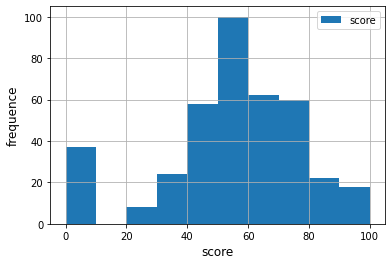

In [29]:
df.score.hist(label='score')
plt.xlabel('score',fontsize = 12)
plt.ylabel('frequence',fontsize = 12)
# plt.title('')
plt.grid(True)
plt.legend()
plt.show()

In [34]:
nul_score = df[df['score'] == 0].copy()
len(nul_score)

37

Имеется 37 оценок 0, т.к. переменная целевая, данные менять нельзя, удалять пока тоже не будем, т.к. причина такой оценки не известна. М.б. ученик не участвовал в экзамене по какой-то причине, а м.б. провалился. Разделить эти причины не предоставляется возможным.

#### school
В переменной нет пустых значений.

In [80]:
df.school.nunique()

2

In [82]:
df.school.unique()

array(['GP', 'MS'], dtype=object)

In [83]:
df.school.value_counts()

GP    344
MS     45
Name: school, dtype: int64

Итого в наборе данных представлены ученики из двух школ.  
Посмотрим, влияет ли эта переменная на итоговую успеваемость или, другими словами, оценим различается ли качество преподавания в разных школах?  
Для этого сначала оценим распределение частоты оценок в зависимости отшколы и выясним есть ли выбросы.

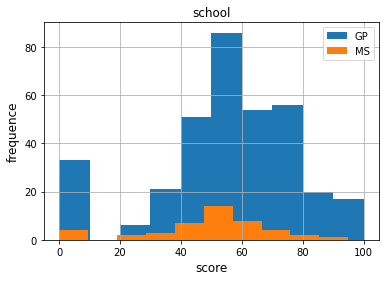

In [25]:
GP = df[df.school == 'GP'].score.copy()
MS = df[df.school == 'MS'].score.copy()
GP.hist(label='GP')
MS.hist(label='MS')
# fig, ax = plt.gcf(), plt.gca()
plt.xlabel('score',fontsize = 12)
plt.ylabel('frequence',fontsize = 12)
plt.title('school')
plt.grid(True)
plt.legend()
plt.show()

Распределение оценок в школах схожее, похоже что нет разницы в качестве обучения.  
Необходимо проверить с помощью теста Стьюдента.

In [17]:
# проверим есть ли выбросы
outliers_check(GP)

Выбросы не найдены


In [18]:
outliers_check(MS)

,score,up_outliers,down_outliers
367,0.0,False,True
383,0.0,False,True
387,0.0,False,True
389,0.0,False,True


Найдены выбросы в распеределении оценок в группе MS.  
Посмотрим, как выглядят на гистограммы распределения с выбросами и без.

25-й перцентиль GP: 40.0, 75-й перцентиль GP: 70.0, GP_IQR: 30.0,  Границы выбросов: [-5.0, 115.0].



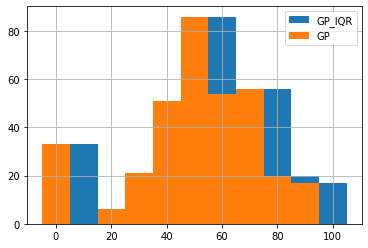

In [19]:
GP_Q1 = GP.quantile(0.25)
GP_Q3 = GP.quantile(0.75)
GP_IQR = GP_Q3 - GP_Q1

print(
'25-й перцентиль GP: {},'.format(GP_Q1),
'75-й перцентиль GP: {},'.format(GP_Q3),
"GP_IQR: {}, ".format(GP_IQR),
"Границы выбросов: [{f}, {l}].\n".format(f=GP_Q1 - 1.5*GP_IQR, l=GP_Q3 + 1.5*GP_IQR))
 
GP.loc[GP.between(
GP_Q1 - 1.5*GP_IQR,
GP_Q3 + 1.5*GP_IQR)].hist(bins = 10, range = (0, 100), label = 'GP_IQR', align = 'right')
GP.hist(label='GP', bins = 10, align = 'left')
plt.legend()


25-й перцентиль MS: 40.0, 75-й перцентиль MS: 65.0, MS_IQR: 25.0,  Границы выбросов: [2.5, 102.5].


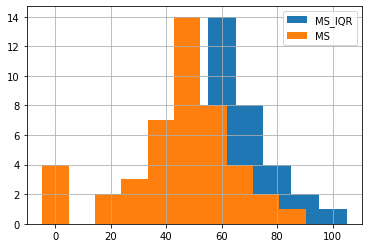

In [85]:
MS_Q1 = MS.quantile(0.25)
MS_Q3 = MS.quantile(0.75)
MS_IQR = MS_Q3 - MS_Q1

print(
'25-й перцентиль MS: {},'.format(MS_Q1),
'75-й перцентиль MS: {},'.format(MS_Q3),
"MS_IQR: {}, ".format(MS_IQR),
"Границы выбросов: [{f}, {l}].".format(f=MS_Q1 - 1.5*MS_IQR, l=MS_Q3 + 1.5*MS_IQR))
 
MS.loc[MS.between(
MS_Q1 - 1.5*MS_IQR,
MS_Q3 + 1.5*MS_IQR)].hist(bins = 10, range = (0, 100), label = 'MS_IQR', align = 'right')
MS.hist(label='MS', bins = 10, align = 'left')
plt.legend()

Для Т-теста заменим выбросы в группе MS на медианое значение. Т.к. все выбросы равны 0, то сделаем это используя только инструменты Pandas.

In [26]:
# заменяем выбросы на медиану
df_temp = df.copy()
df_temp.loc[((df_temp['school'] == 'MS') & (df_temp['score'] == 0)), ['score']] = MS.quantile(0.5)
# проверяем изменения
df_temp[df_temp.index.isin([367,383,387,389])] # индексы строк с выбросамии для группы MS

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
367,MS,F,17,R,NaN,T,1.0,1.0,other,services,reputation,mother,3.0,1.0,1.0,no,yes,yes,no,yes,-3.0,yes,yes,yes,5.0,2.0,1.0,1.0,0.0,50.0
383,MS,M,19,R,GT3,T,1.0,1.0,other,services,other,mother,2.0,1.0,1.0,no,no,no,no,NaN,-3.0,yes,no,no,4.0,3.0,2.0,5.0,0.0,50.0
387,MS,F,19,R,GT3,T,2.0,3.0,services,other,course,mother,1.0,3.0,1.0,no,no,no,yes,no,-9.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,50.0
389,MS,F,18,U,GT3,T,1.0,1.0,other,other,course,mother,NaN,2.0,1.0,no,no,no,yes,yes,-6.0,yes,NaN,no,1.0,1.0,1.0,5.0,0.0,50.0


Воспользуемся Т-тестом для оценки значимости различий между оценками полученными в разных школах.
Т.к. выборки достаточно большие и случайные, согласно центральной предельной теореме мы можем считать что их распределение приблизительно нормальное. 

In [27]:
MS = df_temp[df_temp.school == 'MS'].score.copy() # обновляем значение переменной 
weightstats.ttest_ind(GP,MS) # T test для выборки

(-0.35562179318461723, 0.7223175780510509, 387.0)

p-value = 0.72, нулевая гипотеза подтверждается, между средними выборок нет различий.
Можно предположить, что уровень преподавания в этих школах одинаковый.  
А значит сама эта переменная не влияет на целевую.

#### sex
sex — пол ученика ('F' - женский, 'M' - мужской)

In [41]:
display(df.sex.nunique())
display(df.sex.unique())
display(df.sex.value_counts())

2

array(['F', 'M'], dtype=object)

F    204
M    185
Name: sex, dtype: int64

Пропусков нет, два уникальных значения. Девочек немного больше чем мальчиков.  
Оценим, влияет ли пол на успеваемость?

In [39]:
# сгуппируем оценки по полу
f = df[df.sex == 'F'].score.copy() 
m = df[df.sex == 'M'].score.copy() 

In [43]:
outliers_check(m)# выбросы у мальчиков

,score,up_outliers,down_outliers
128,0.0,False,True
134,0.0,False,True
136,0.0,False,True
140,0.0,False,True
144,0.0,False,True
148,0.0,False,True
150,0.0,False,True
153,0.0,False,True
160,0.0,False,True
162,0.0,False,True


In [82]:
outliers_check(f)# выбросы у девочек

,score,up_outliers,down_outliers
130,0.0,False,True
131,0.0,False,True
135,0.0,False,True
137,0.0,False,True
146,0.0,False,True
168,0.0,False,True
173,0.0,False,True
221,0.0,False,True
259,0.0,False,True
264,0.0,False,True


В обоих группах нулевые значения являются выбросами.

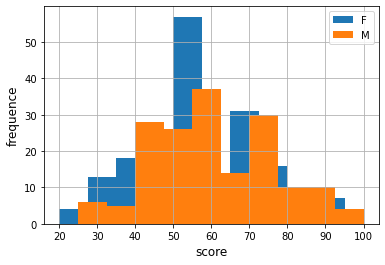

In [79]:
free_outliers_hist(f,'F','score')
free_outliers_hist(m,'M','score')

In [84]:
# оценимним есть ли статистически значимые различия в оценках между M и F без выбросов.
weightstats.ttest_ind(delite_outliers(f),delite_outliers(m)) # T test для выборки

(-1.9267806670436756, 0.054816294332242284, 350.0)

p-value 0.055, нулевая гипотеза подтверждается, различия не значимы.

#### Age

Переменная числовая, не содержит пропусков.

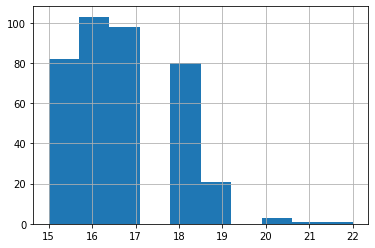

In [87]:
df.age.hist()

Распределение асиметриченое.

#### address

Категориальная переменная — тип адреса ученика ('U' - городской, 'R' - за городом)  
Содержит 15 пропусков.

In [91]:
df.address.unique()

array(['U', nan, 'R'], dtype=object)

In [95]:
u = df[df.address == 'U'].score.copy()
r = df[df.address == 'R'].score.copy()

In [96]:
outliers_check(u)# выбросы у городских учеников

,score,up_outliers,down_outliers
131,0.0,False,True
135,0.0,False,True
137,0.0,False,True
140,0.0,False,True
144,0.0,False,True
146,0.0,False,True
148,0.0,False,True
150,0.0,False,True
153,0.0,False,True
162,0.0,False,True


In [97]:
outliers_check(r)# выбросы у загородных учеников

Выбросы не найдены


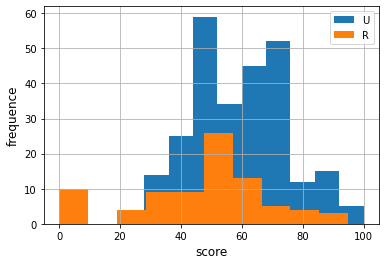

In [98]:
free_outliers_hist(u,'U','score')
free_outliers_hist(r,'R','score')

In [99]:
# оценимним есть ли статистически значимые различия в оценках между U и R без выбросов.
weightstats.ttest_ind(delite_outliers(u),r) # T test для выборки

(5.234280072765354, 2.879045601106688e-07, 346.0)

In [101]:
weightstats.ttest_ind(u,r) # T test для выборки

(2.33264133175904, 0.020199635381958233, 372.0)

p-value = 2.88*10^-7  
Можно сделать вывод о том, что городские ученики в целом успешнее показали себя на экзамене.

#### famsize
famsize — размер семьи('LE3' <= 3, 'GT3' >3)  
Категориальная переменная.  
27 пропусков  

In [104]:
df.famsize.unique()

array([nan, 'GT3', 'LE3'], dtype=object)

In [110]:
GT3 = df[df.famsize == 'GT3'].score.copy()
LE3 = df[df.famsize == 'LE3'].score.copy()

In [112]:
outliers_check(GT3)# выбросы у учеников из большой семьи

Выбросы не найдены


In [113]:
outliers_check(LE3)# выбросы у учеников из малой семьи

,score,up_outliers,down_outliers
150,0.0,False,True
160,0.0,False,True
162,0.0,False,True
242,0.0,False,True
259,0.0,False,True
310,0.0,False,True
333,0.0,False,True


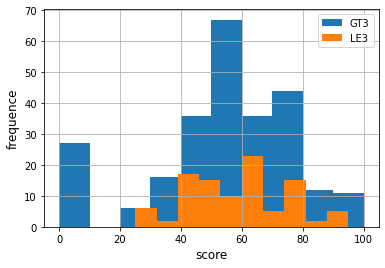

In [116]:
free_outliers_hist(GT3,'GT3','score')
free_outliers_hist(LE3,'LE3','score')

In [119]:
# оценимним есть ли статистически значимые различия в оценках между LE3 и GT3 без выбросов.
weightstats.ttest_ind(delite_outliers(LE3),delite_outliers(GT3)) # T test для выборки

(2.740928076392295, 0.006438263594040736, 353.0)

In [132]:
display(delite_outliers(LE3).mean())
display(GT3.mean())

58.5

51.509803921568626

Различия в оценках статистически значимы между учениками малых и больших семей, в пользу LE3.

#### Pstatus
Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
Категориальная переменная.  
45 пропусков

In [141]:
display(df.p_status.unique())
df.p_status.value_counts()

array(['A', nan, 'T'], dtype=object)

T    308
A     36
Name: p_status, dtype: int64

In [142]:
t = df[df.p_status == 'T'].score.copy()
a = df[df.p_status == 'A'].score.copy()

In [143]:
outliers_check(t)# выбросы у учеников проживающих с родителями

Выбросы не найдены


In [144]:
outliers_check(a)

,score,up_outliers,down_outliers
137,0.0,False,True
343,0.0,False,True


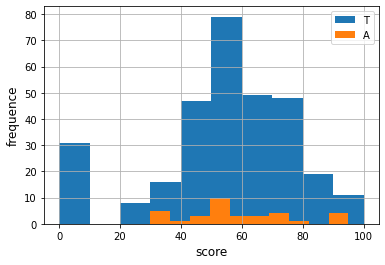

In [145]:
free_outliers_hist(t,'T','score')
free_outliers_hist(a,'A','score')

In [146]:
# оценимним есть ли статистически значимые различия в оценках между T и A без выбросов.
weightstats.ttest_ind(delite_outliers(t),delite_outliers(a)) # T test для выборки

(-1.6383042819176197, 0.1022832713863409, 340.0)

P-value = 0.1, нулевая гипотеза не отвергается.
Статус проживания не влияет на оценку.

#### Medu
Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)  
Переменная числовая, ранговая.   
Три пропущенных значения.

In [157]:
display(df.m_edu.unique())
display(df.m_edu.value_counts())

array([ 4.,  1.,  3.,  2., nan,  0.])

4.0    131
2.0    100
3.0     96
1.0     56
0.0      3
Name: m_edu, dtype: int64

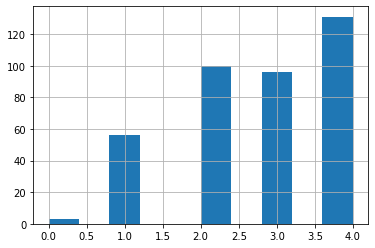

In [159]:
df.m_edu.hist()

#### Fedu
Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
Переменная числовая, ранговая.
27 пропущенных значений.

array([ 4.,  1.,  2.,  3., 40., nan,  0.])

2.0     105
3.0      94
4.0      88
1.0      75
0.0       2
40.0      1
Name: f_edu, dtype: int64

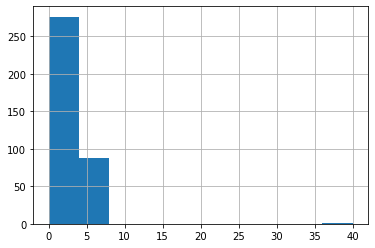

In [164]:
display(df.f_edu.unique())
display(df.f_edu.value_counts())
df.f_edu.hist()

значение 40 - явно ошибка, заменим его на 4

array([ 4.,  1.,  2.,  3., nan,  0.])

2.0    105
3.0     94
4.0     89
1.0     75
0.0      2
Name: f_edu, dtype: int64

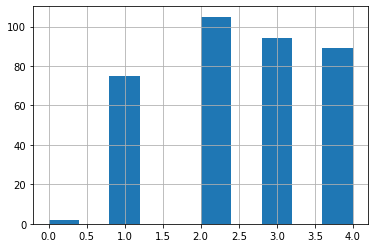

In [166]:
df[df.f_edu == 40] = 4
display(df.f_edu.unique())
display(df.f_edu.value_counts())
df.f_edu.hist()

В целом у пап с высшим образованием похуже чем у мам. М.б. они были заняты поиском образованной жены?

##### Mjob
Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
Переменная категориальная.
19 пропусков.

In [169]:
display(df.m_job.unique())
display(df.m_job.value_counts())

array(['at_home', 'health', 'other', 'services', 'teacher', 4, nan],
      dtype=object)

other       127
services     97
at_home      58
teacher      55
health       32
4             1
Name: m_job, dtype: int64

Увеличим число пропусков в переменной до 20, заменим 4 на None.

array(['at_home', 'health', 'other', 'services', 'teacher', None, nan],
      dtype=object)

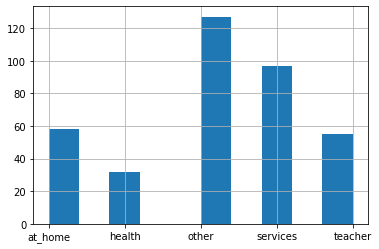

In [175]:
df[df.m_job == 4] = None
display(df.m_job.unique())
df.m_job.hist()

#### Fjob
Fjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)  
Переменная категориальная. 37 пропусков.

In [179]:
display(df.f_job.unique())
display(df.f_job.value_counts())

array(['teacher', 'other', nan, 'health', None, 'services', 'at_home'],
      dtype=object)

other       193
services     99
teacher      29
at_home      16
health       15
Name: f_job, dtype: int64

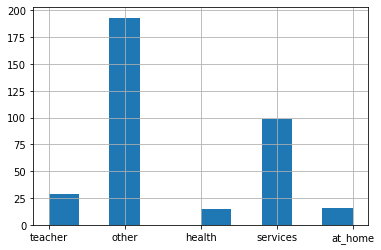

In [180]:
df.f_job.hist()

Можно сказать, что папы меньше работают дома и учителями,  в отличие от мам, но это не имеет отношения к сути дела.

#### reason
reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
Переменная категориальная.  
18 пропусков. 

In [182]:
display(df.reason.unique())
display(df.reason.value_counts())

array(['course', 'other', 'home', 'reputation', None, nan], dtype=object)

course        135
reputation    101
home          101
other          34
Name: reason, dtype: int64

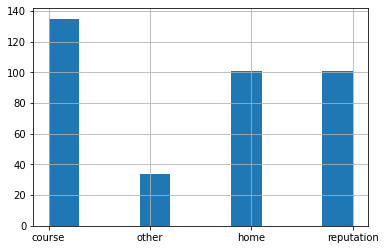

In [183]:
df.reason.hist()

#### guardian
guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)  
Переменная категориальная.  
32 пропуска

In [188]:
display(df.guardian.unique())
display(df.guardian.value_counts())

array(['mother', 'father', None, 'other', nan], dtype=object)

mother    248
father     85
other      24
Name: guardian, dtype: int64

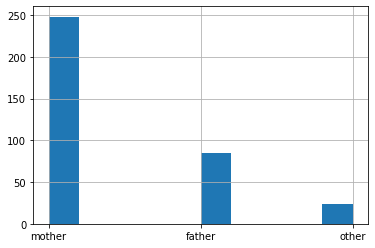

In [187]:
df.guardian.hist()

#### traveltime
traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)  
Переменная числовая, ранговая.  
28 пропусков

In [190]:
display(df.traveltime.unique())
display(df.traveltime.value_counts())

array([ 2.,  1., nan,  3.,  4.])

1.0    239
2.0     94
3.0     20
4.0      7
Name: traveltime, dtype: int64

Большинство учеников живёт рядом со школой.

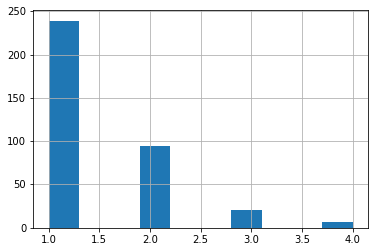

In [191]:
df.traveltime.hist()

#### studytime
studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)  
Переменная числовая, ранговая.  
7 пропусков

In [192]:
display(df.studytime.unique())
display(df.studytime.value_counts())

array([ 2.,  3., nan,  1.,  4.])

2.0    189
1.0    103
3.0     62
4.0     27
Name: studytime, dtype: int64

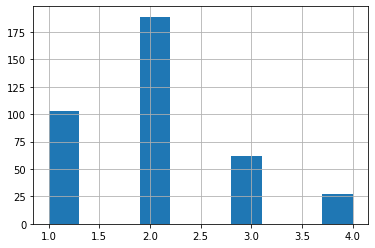

In [194]:
df.studytime.hist()

Большинство учеников тратит на внекласную учёбу не более 5 часов в сутки.

#### failures
failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)  
Переменная числовая, ранговая.
23 пропуска

In [195]:
display(df.failures.unique())
display(df.failures.value_counts())

array([ 0.,  3., nan,  2.,  1.])

0.0    289
1.0     48
2.0     15
3.0     14
Name: failures, dtype: int64

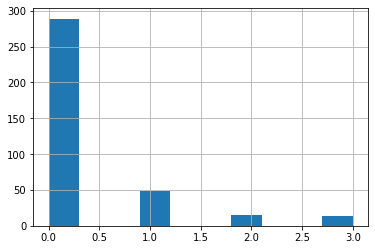

In [197]:
df.failures.hist()

#### schoolsup
schoolsup — дополнительная образовательная поддержка (yes или no)  
Категориальная переменная.  
10 пропусков

In [198]:
display(df.schoolsup.unique())
display(df.schoolsup.value_counts())

array(['yes', 'no', None, nan], dtype=object)

no     330
yes     49
Name: schoolsup, dtype: int64

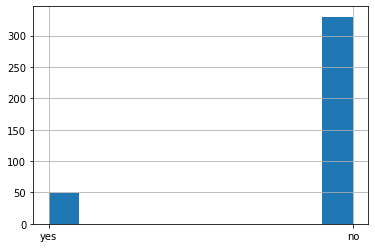

In [199]:
df.schoolsup.hist()

In [249]:
no = df[df.schoolsup == 'no'].score.copy()
yes = df[df.schoolsup == 'yes'].score.copy()
print('no')
display(outliers_check(no)) 
print('yes')
outliers_check(yes)

no


,score,up_outliers,down_outliers
128,0.0,False,True
130,0.0,False,True
131,0.0,False,True
134,0.0,False,True
135,0.0,False,True
136,0.0,False,True
137,0.0,False,True
144,0.0,False,True
146,0.0,False,True
148,0.0,False,True


yes


,score,up_outliers,down_outliers
140,0.0,False,True
222,85.0,True,False


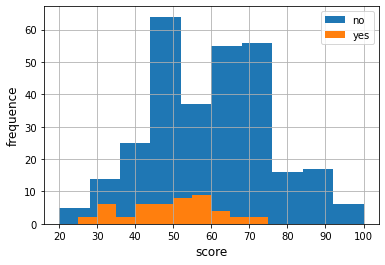

In [250]:
free_outliers_hist(no,'no','score')
free_outliers_hist(yes,'yes','score')

In [227]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(no),delite_outliers(yes)) # T test для выборки

(5.076618739270405, 6.34088672972889e-07, 340.0)

In [228]:
print(f'среднее значене оценок группы no = {delite_outliers(no).mean()}')
print(f'среднее значене оценок группы yes = {delite_outliers(yes).mean()}')

среднее значене оценок группы no = 59.610169491525426
среднее значене оценок группы yes = 47.234042553191486


Большинство учащихся не имеют дополнительной образовательной поддержки. и как это ни странно у них значимо выше показатель оценки.

#### famsup
famsup — семейная образовательная поддержка (yes или no)  
Категориальная переменная.  
39 пропусков

In [201]:
display(df.famsup.unique())
display(df.famsup.value_counts())


array(['no', 'yes', None, nan], dtype=object)

yes    215
no     135
Name: famsup, dtype: int64

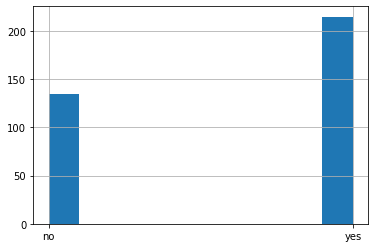

In [202]:
df.famsup.hist()

In [254]:
no = df[df.famsup == 'no'].score.copy()
yes = df[df.famsup == 'yes'].score.copy()
print('no')
display(outliers_check(no)) 
print('yes')
outliers_check(yes)

no


,score,up_outliers,down_outliers
136,0.0,False,True
150,0.0,False,True
160,0.0,False,True
162,0.0,False,True
173,0.0,False,True
239,0.0,False,True
242,0.0,False,True
259,0.0,False,True
310,0.0,False,True
332,0.0,False,True


yes
Выбросы не найдены


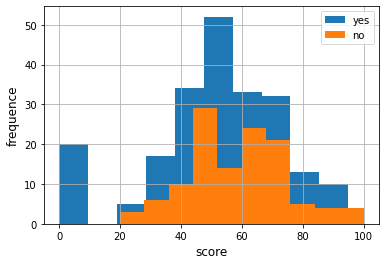

In [255]:
free_outliers_hist(yes,'yes','score')
free_outliers_hist(no,'no','score')


In [230]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(no),delite_outliers(yes)) # T test для выборки

(2.898370500278022, 0.003999014455257364, 334.0)

In [231]:
print(f'среднее значене оценок группы no = {delite_outliers(no).mean()}')
print(f'среднее значене оценок группы yes = {delite_outliers(yes).mean()}')

среднее значене оценок группы no = 58.583333333333336
среднее значене оценок группы yes = 51.71296296296296


Более чем половине учачихся помогают дома с учёбой. Однако оценки на экзамене у них значимо ниже чем у самостоятельных учеников. Наблюдается тенденция...

#### paid
paid — дополнительные платные занятия по математике (yes или no)  
Категориальная переменная.  
40 пропусков

In [205]:
display(df.paid.unique())
display(df.paid.value_counts())

array(['no', nan, 'yes', None], dtype=object)

no     196
yes    153
Name: paid, dtype: int64

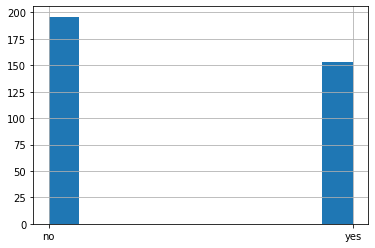

In [206]:
df.paid.hist()

In [256]:
no = df[df.paid == 'no'].score.copy()
yes = df[df.paid == 'yes'].score.copy()
print('no')
display(outliers_check(no)) 
print('yes')
outliers_check(yes)

no
Выбросы не найдены


None

yes


,score,up_outliers,down_outliers
168,0.0,False,True
259,0.0,False,True
264,0.0,False,True
296,0.0,False,True
316,0.0,False,True
337,0.0,False,True
367,0.0,False,True


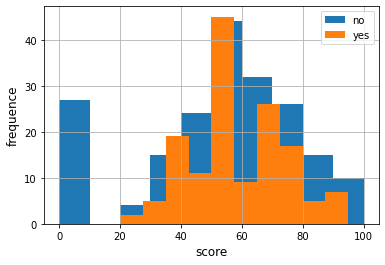

In [258]:
free_outliers_hist(no,'no','score')
free_outliers_hist(yes,'yes','score')


In [233]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(no),delite_outliers(yes)) # T test для выборки

(-3.0574872740000334, 0.002408408256306475, 341.0)

In [234]:
print(f'среднее значене оценок группы no = {delite_outliers(no).mean()}')
print(f'среднее значене оценок группы yes = {delite_outliers(yes).mean()}')

среднее значене оценок группы no = 50.35532994923858
среднее значене оценок группы yes = 57.636986301369866


Ученики, которые брали дополнительные платные занятия по предмету успешнее на экзамене.

#### activities
activities — дополнительные внеучебные занятия (yes или no)  
Категориальная переменная.   
14 пропусков

In [238]:
display(df.activities.unique())
display(df.activities.value_counts())

array(['no', 'yes', nan], dtype=object)

yes    192
no     183
Name: activities, dtype: int64

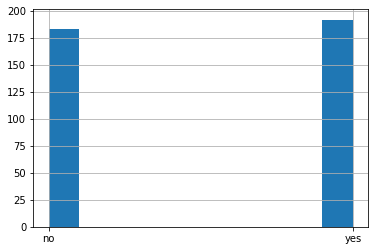

In [239]:
df.activities.hist()

In [259]:
no = df[df.activities == 'no'].score.copy()
yes = df[df.activities == 'yes'].score.copy()
print('no')
display(outliers_check(no)) 
print('yes')
outliers_check(yes)

no


,score,up_outliers,down_outliers
130,0.0,False,True
134,0.0,False,True
136,0.0,False,True
144,0.0,False,True
146,0.0,False,True
148,0.0,False,True
150,0.0,False,True
153,0.0,False,True
168,0.0,False,True
239,0.0,False,True


yes


,score,up_outliers,down_outliers
128,0.0,False,True
131,0.0,False,True
135,0.0,False,True
137,0.0,False,True
162,0.0,False,True
170,0.0,False,True
173,0.0,False,True
221,0.0,False,True
242,0.0,False,True
259,0.0,False,True


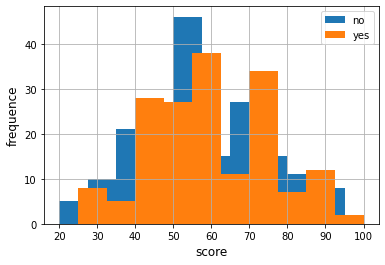

In [260]:
free_outliers_hist(no,'no','score')
free_outliers_hist(yes,'yes','score')

In [242]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(no),delite_outliers(yes)) # T test для выборки

(-1.1052268629252946, 0.26984739556215265, 338.0)

In [243]:
print(f'среднее значене оценок группы no = {delite_outliers(no).mean()}')
print(f'среднее значене оценок группы yes = {delite_outliers(yes).mean()}')

среднее значене оценок группы no = 56.845238095238095
среднее значене оценок группы yes = 58.80813953488372


Приблизительно равное значение распределения показателя _непизвестных_ дополнительных внеучебных занятий.
На итоговоую оценку не влияет.

#### nursery
nursery — посещал детский сад (yes или no)  
Категориальная переменная.  
15 пропусков

In [244]:
display(df.nursery.unique())
display(df.nursery.value_counts())

array(['yes', 'no', nan], dtype=object)

yes    297
no      77
Name: nursery, dtype: int64

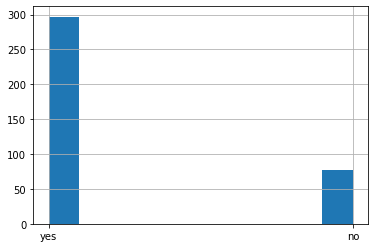

In [245]:
df.nursery.hist()

In [261]:
no = df[df.nursery == 'no'].score.copy()
yes = df[df.nursery == 'yes'].score.copy()
print('no')
display(outliers_check(no)) 
print('yes')
outliers_check(yes)

no


,score,up_outliers,down_outliers
131,0.0,False,True
137,0.0,False,True
168,0.0,False,True
170,0.0,False,True
173,0.0,False,True
242,0.0,False,True
310,0.0,False,True
333,0.0,False,True
387,0.0,False,True


yes
Выбросы не найдены


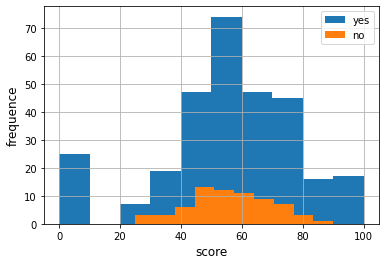

In [263]:
free_outliers_hist(yes,'yes','score')
free_outliers_hist(no,'no','score')


In [247]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(no),delite_outliers(yes)) # T test для выборки

(1.2708240788945824, 0.2046050440668301, 363.0)

Нулевая гипотеза не отвергается, следовательно посещение детского сада не сказывается на оценку по математике.

#### higher 
higher — хочет получить высшее образование (yes или no)  
Категориальная переменная.  
20 пропусков

In [264]:
display(df.higher.unique())
display(df.higher.value_counts())

array(['yes', nan, 'no'], dtype=object)

yes    350
no      19
Name: higher, dtype: int64

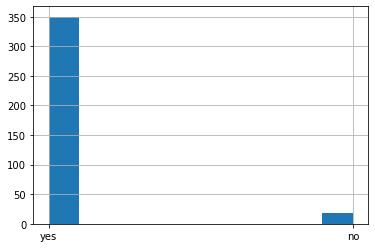

In [265]:
df.higher.hist()

In [266]:
no = df[df.higher == 'no'].score.copy()
yes = df[df.higher == 'yes'].score.copy()
print('no')
display(outliers_check(no)) 
print('yes')
outliers_check(yes)

no
Выбросы не найдены


None

yes


,score,up_outliers,down_outliers
128,0.0,False,True
130,0.0,False,True
131,0.0,False,True
134,0.0,False,True
135,0.0,False,True
136,0.0,False,True
137,0.0,False,True
140,0.0,False,True
144,0.0,False,True
146,0.0,False,True


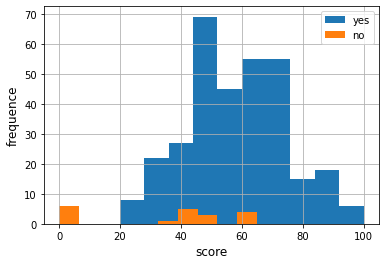

In [267]:
free_outliers_hist(yes,'yes','score')
free_outliers_hist(no,'no','score')


In [268]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(no),delite_outliers(yes)) # T test для выборки

(-6.058543802886835, 3.6725768910858153e-09, 337.0)

In [269]:
print(f'среднее значене оценок группы no = {delite_outliers(no).mean()}')
print(f'среднее значене оценок группы yes = {delite_outliers(yes).mean()}')

среднее значене оценок группы no = 33.68421052631579
среднее значене оценок группы yes = 58.078125


Судя по резулльтатам Т-теста, желающие получить высшее образование, лучше изучали предмет.

#### internet
internet — наличие интернета дома (yes или no)  
Категориальная переменная.  
34 пропуска

In [273]:
display(df.internet.unique())
display(df.internet.value_counts())

array([nan, 'yes', 'no'], dtype=object)

yes    300
no      55
Name: internet, dtype: int64

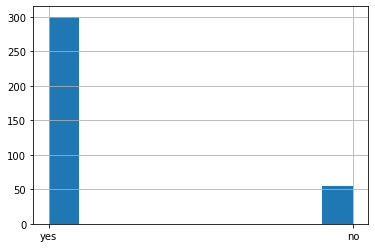

In [275]:
df.internet.hist()

In [276]:
no = df[df.internet == 'no'].score.copy()
yes = df[df.internet == 'yes'].score.copy()
print('no')
display(outliers_check(no)) 
print('yes')
outliers_check(yes)

no


,score,up_outliers,down_outliers
134,0.0,False,True
136,0.0,False,True
221,0.0,False,True
293,90.0,True,False
306,90.0,True,False
310,0.0,False,True
334,0.0,False,True
383,0.0,False,True


yes
Выбросы не найдены


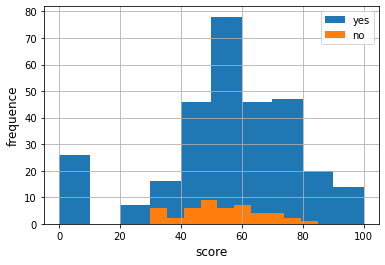

In [277]:
free_outliers_hist(yes,'yes','score')
free_outliers_hist(no,'no','score')

In [278]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(no),delite_outliers(yes)) # T test для выборки

(0.14746394814362643, 0.8828519742856953, 345.0)

Судя по резулльтатам Т-теста, наличие/отсутствие интернета не влияет на знание математики.

#### romantic
romantic — в романтических отношениях (yes или no)  
Категориальная переменная.
31 пропуск

In [280]:
display(df.romantic.unique())
display(df.romantic.value_counts())

array(['no', nan, 'yes'], dtype=object)

no     235
yes    123
Name: romantic, dtype: int64

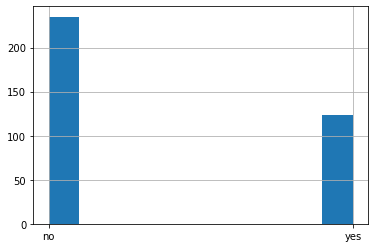

In [281]:
df.romantic.hist()

In [282]:
no = df[df.internet == 'no'].score.copy()
yes = df[df.internet == 'yes'].score.copy()
print('no')
display(outliers_check(no)) 
print('yes')
outliers_check(yes)

no


,score,up_outliers,down_outliers
134,0.0,False,True
136,0.0,False,True
221,0.0,False,True
293,90.0,True,False
306,90.0,True,False
310,0.0,False,True
334,0.0,False,True
383,0.0,False,True


yes
Выбросы не найдены


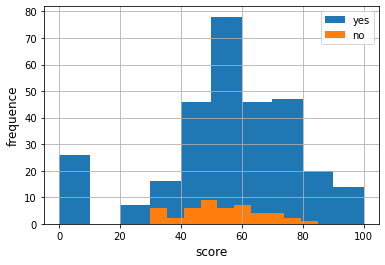

In [283]:
free_outliers_hist(yes,'yes','score')
free_outliers_hist(no,'no','score')

In [284]:
# оценимним есть ли статистически значимые различия в оценках между yes и no без выбросов.
weightstats.ttest_ind(delite_outliers(no),delite_outliers(yes)) # T test для выборки

(0.14746394814362643, 0.8828519742856953, 345.0)

Судя по резулльтатам Т-теста, наличие/отсутствие романтических отношений не влияет на знание математики.

#### famrel
famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)  
Переменная числовая, ранговая.  
27 пропусков

In [285]:
display(df.famrel.unique())
display(df.famrel.value_counts())

array([ 4.,  5.,  3., nan, -1.,  2.,  1.])

 4.0    178
 5.0     97
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

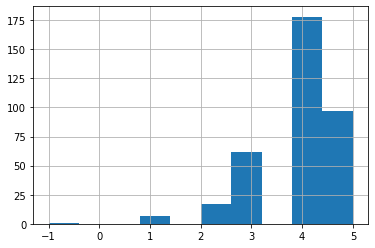

In [286]:
df.famrel.hist()

-1 явная ошибка, исправим на 1

In [287]:
df[df.famrel == -1] = 1

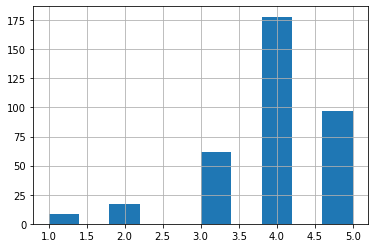

In [288]:
df.famrel.hist()

#### freetime
freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)  
Переменная числовая, ранговая.  
9 пропусков

In [289]:
display(df.freetime.unique())
display(df.freetime.value_counts())

array([ 3.,  2.,  4.,  1.,  5., nan])

3.0    152
4.0    110
2.0     62
5.0     37
1.0     19
Name: freetime, dtype: int64

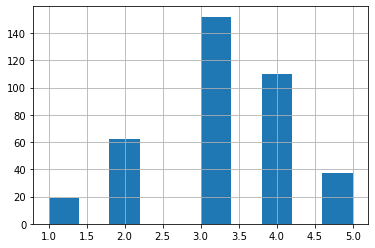

In [290]:
df.freetime.hist()

#### goout
goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)  
Переменная числовая, ранговая.  
7 пропусков

In [291]:
display(df.goout.unique())
display(df.goout.value_counts())

array([ 4.,  3.,  2.,  1.,  5., nan])

3.0    126
2.0    100
4.0     81
5.0     51
1.0     24
Name: goout, dtype: int64

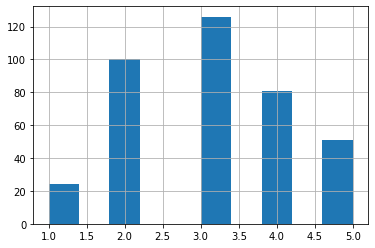

In [292]:
df.goout.hist()

Судя по распределению свободного времени и проведению времени с друзьями, эти показатели должны неплохо коррелировать, оценим позже.

#### health
health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
Переменная числовая, ранговая.  
15 пропусков

In [293]:
display(df.health.unique())
display(df.health.value_counts())

array([ 3.,  5.,  1.,  2.,  4., nan])

5.0    136
3.0     88
4.0     60
1.0     48
2.0     42
Name: health, dtype: int64

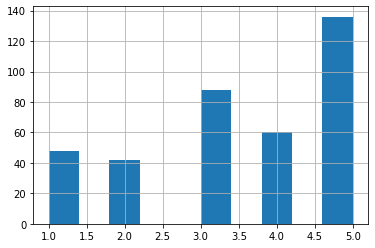

In [294]:
df.health.hist()

#### absences 
absences — количество пропущенных занятий  
Переменная числовая  
11 пропусков

In [295]:
display(df.absences.unique())
display(df.absences.value_counts())

array([  6.,   4.,  10.,   2.,   0.,  16.,  nan,   1.,   7.,   8.,  25.,
        14.,  12.,  54.,  18.,  26.,  20.,  56.,  24.,  28.,   5.,  13.,
        15.,  22.,   3., 385.,  21.,  75.,  30.,  19.,   9.,  11.,  38.,
        40.,  23.,  17., 212.])

0.0      110
2.0       60
4.0       52
6.0       30
8.0       20
10.0      17
12.0      12
14.0      11
16.0       7
3.0        7
7.0        6
5.0        5
18.0       5
20.0       4
1.0        4
22.0       3
9.0        3
13.0       2
15.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
212.0      1
28.0       1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
24.0       1
Name: absences, dtype: int64

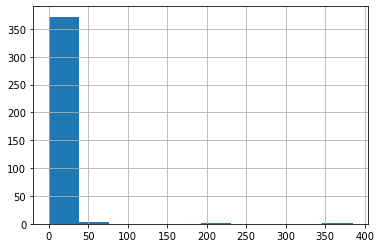

In [296]:
df.absences.hist()

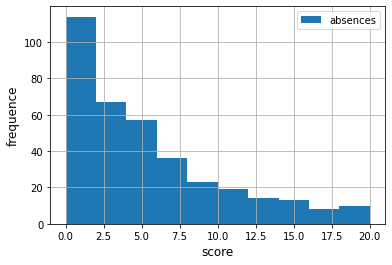

In [297]:
free_outliers_hist(df.absences,'absences','score')

Всё что выше 20 пропущенных часов - выбросы.
Распределение экспаненциальное.

#### studytime, granular
Смысл переменной неизвестен.  
Переменная числовая.  
7 пропусков

In [298]:
display(df.studytime_granular.unique())
display(df.studytime_granular.value_counts())

array([ -6.,  -9.,  -3.,  nan,   1., -12.])

-6.0     189
-3.0     102
-9.0      63
-12.0     27
 1.0       1
Name: studytime_granular, dtype: int64

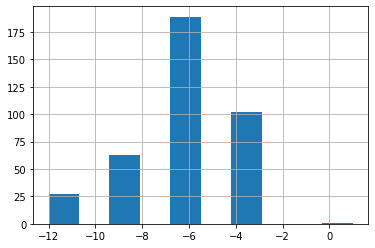

In [299]:
df.studytime_granular.hist()